In [2]:
%matplotlib inline

from matplotlib_inline import backend_inline
import numpy as np
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt
from datetime import datetime
from torch.utils import data
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

backend_inline.set_matplotlib_formats('svg')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
plt.rcParams['font.sans-serif'] = ['SimHei']

## 加载数据

In [3]:
# convert str to datatime
# 将字符串转换为时间
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# load .mat data
# 加载.mat格式的数据
def loadMat(matfile):
    data_mat = scipy.io.loadmat(matfile)
    filename = matfile.split("/")[-1].split(".")[0]
    col = data_mat[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data_mat = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data_mat.append(d1)

    return data_mat

# get capacity data
# 得到电池容量的数据
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]

Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = './dataset/'

Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data_mat = loadMat(path)
    Battery[name] = getBatteryCapacity(data_mat)

Load Dataset B0005.mat ...


C:\Users\Coyle\AppData\Local\Temp\ipykernel_23280\2811494779.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2


Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


In [4]:
len(Battery['B0018'][0]), len(Battery['B0018'][1])

(132, 132)

## 画出数据

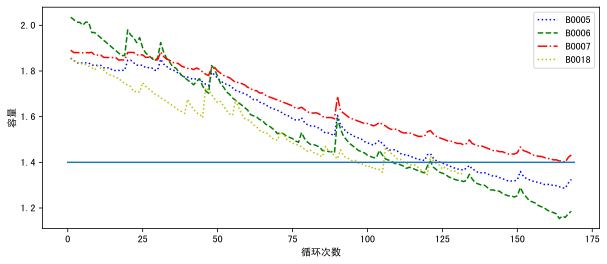

In [5]:
%matplotlib inline

color_list = ['b:', 'g--', 'r-.', 'y:']
# 1.创建画布
plt.figure(figsize=(10, 4), dpi=80)
plt.xlabel('循环次数')
plt.ylabel('容量')

# 2.绘制折线图
for name,color in zip(Battery_list, color_list):
    plt.plot(Battery[name][0], Battery[name][1], color)
    
plt.plot([i for i in range(170)], [1.4] * 170)

# 图例
plt.legend([name for name in Battery_list])

## 构建训练序列数据

In [6]:
# 构建数据
# 采用 留一评估：一组数据为测试集，其他所有数据全部拿来训练
# train_x 的维度是 window_size ，总样本数为 421
# train_y 的维度是1，总样本数为421
# train_data 是模型预测时的真实数据，用来预测下一时刻的容量，长度为 window_size
# test_data 是 真实的容量数据，用来检验模型的各种参数

def build_seq(text, window_size):
    # text:list of capacity
    x, y = [], []
    for i in range(len(text) - window_size):
        sequence = text[i:i + window_size]
        # target = text[i + window_size] # y 只有一列
        target = text[i + 1:i + 1 + window_size] # y 有 window_size 列
        x.append(sequence)
        y.append(target)

    return np.array(x), np.array(y)

def get_train_test_data(data_dict, name, window_size=16):
    data_sequence = data_dict[name][1]
    train_data, test_data = data_sequence[:window_size], data_sequence[window_size:]
    
    train_x, train_y = None, None
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_seq(text=v[1], window_size=window_size)
            if train_x is None:
                train_x = data_x
                train_y = data_y
            else:
                train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]

    return train_x, train_y, list(train_data), list(test_data)

def load_capacity_data(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

## 创建评估指标函数

In [7]:
# 平均绝对误差、均方根误差
def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return mae, rmse

# 相对误差
# B0005 第125次循环后达到阈值1.4
# B0006 第109次循环后达到阈值1.4
# B0007 数据集中无任何值小于1.4，所以无法达到阈值1.4
# B0018 第97次循环后达到阈值1.4
def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), len(y_predict)
    for i in range(len(y_test) - 1):
        if y_test[i] <= threshold >= y_test[i + 1]:
            true_re = i + 1
            break
    # print('true_re', true_re)
    for i in range(len(y_predict) - 1):
        if y_predict[i] <= threshold >= y_predict[i + 1]:
            pred_re = i + 1
            break
    return abs(true_re - pred_re) / true_re

# relative_error(Battery['B0007'][1], Battery['B0007'][1], 1.4)

## 随机种子

In [8]:
# 设置随机种子
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)  # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed)  # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

In [9]:
# 测试 train_iter 的数据是否正确
def validate_train_iter(train_iter):
    for X, Y in train_iter:
        print(X.shape)
        print(Y.shape)
        print(X[1])
        print(Y[1])
        print('Y[:, -1]', Y[:, -1].reshape(-1, 1).shape)
        # break

    print(torch.from_numpy(np.array(Battery['B0006'][1][1:18])))

train_x, train_y, train_data, test_data = get_train_test_data(Battery, Battery_list[0], window_size=16)
train_x = torch.from_numpy(train_x.astype(np.float32))
train_y = torch.from_numpy(train_y.astype(np.float32))
train_iter = load_capacity_data((train_x, train_y), 420, is_train=False)
validate_train_iter(train_iter)
len(train_x)

torch.Size([420, 16])
torch.Size([420, 16])
tensor([2.0251, 2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572,
        1.9456, 1.9348, 1.9233, 1.9119, 1.9011, 1.8892, 1.8783])
tensor([2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572, 1.9456,
        1.9348, 1.9233, 1.9119, 1.9011, 1.8892, 1.8783, 1.8676])
Y[:, -1] torch.Size([420, 1])
tensor([2.0251, 2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572,
        1.9456, 1.9348, 1.9233, 1.9119, 1.9011, 1.8892, 1.8783, 1.8676],
       dtype=torch.float64)


420

## 层规范化

In [10]:
# 层规范化
# 假设此时输入的数据维度是[3, 4]，则对3个长度为4的向量求均值方差，得到3个均值和3个方差
# 分别对这3行进行归一化（每一行的4个数字都是均值为0，方差为1） 
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

## 前馈网络层

In [11]:
# 前馈网络层
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 8])

## 注意力机制块

In [12]:
# 注意力机制块
class AttentionBlock(nn.Module):
    """注意力机制块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens, num_heads,
                 norm_shape, ffn_num_input, ffn_num_hiddens, dropout, use_bias, **kwargs):
        super(AttentionBlock, self).__init__(**kwargs)
        
        # 多头注意力层
        # nn.MultiheadAttention(embed_dim=16,num_heads=4,kdim=16,vdim=1,batch_first=True)
        self.attention = nn.MultiheadAttention(embed_dim=query_size, num_heads=num_heads, kdim=key_size, vdim=value_size, batch_first=True)
        
        # 层规范化
        self.addnorm1 = AddNorm(norm_shape, dropout)
        
        # 前馈网络层
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        
        # 层规范化
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, Y):
        batch_size_X, seq_len, feature_size = X.shape
        
        batch_size_Y = Y.shape[0]
        
        if batch_size_X != batch_size_Y:
            Y = Y.reshape(batch_size_X, -1, feature_size)
        
        Value = Y[:, :, -1].reshape(batch_size_X, -1, 1)
        # print('Value.shape', Value.shape)
        
        # attention 的输出 shape: (batch_size, 1, window_size)
        attn_output, _ = self.attention(X, Y, Value)
        # addnorm1 的输出 shape: (batch_size, 1, window_size)
        X = self.addnorm1(X, attn_output)
        
        # ffn 的输出 shape: (batch_size, 1, window_size)
        # addnorm2 的输出 shape: (batch_size, 1, window_size)
        X = self.addnorm2(X, self.ffn(X))
        
        return X
    

# 测试 输出形状
atten = AttentionBlock(16, 16, 1, 16, 4, [1, 16], 16, 32, 0.5, False)
X = torch.rand(1, 1, 16)
Y = torch.rand(420, 1, 16)
out = atten(X, Y)
out.shape

torch.Size([1, 1, 16])

## 2维数据的残差卷积网络

In [13]:
# 残差网络
class Residual1D(nn.Module):
    def __init__(self, input_channels, num_channels, kernel_size, strides=1):
        super().__init__()
        
        self.conv1 = nn.Conv1d(input_channels, num_channels, kernel_size=3, stride=strides, padding=1)
        self.conv2 = nn.Conv1d(num_channels, num_channels, kernel_size=3, stride=strides, padding=1)
        
        self.bn1 = nn.BatchNorm1d(num_channels)
        self.bn2 = nn.BatchNorm1d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        
        Y += X
        return F.relu(Y)


blk = Residual1D(1, 8, 3)
X = torch.rand(420, 1, 16)
Y = blk(X)
Y.shape

torch.Size([420, 8, 16])

## 深度降噪自编码器

In [14]:
class DeepDenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim, noise_factor):
        super(DeepDenoisingAutoencoder, self).__init__()
        
        self.noise_factor = noise_factor
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, int(input_dim / 2)),
            nn.ReLU(),
            nn.Linear(int(input_dim / 2), int(input_dim / 4)),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(int(input_dim / 4), int(input_dim / 2)),
            nn.ReLU(),
            nn.Linear(int(input_dim / 2), input_dim),
            nn.ReLU(),
        )

    def forward(self, X):
        X = X + self.noise_factor * torch.randn_like(X)
        
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return encoded, decoded


ddae = DeepDenoisingAutoencoder(16, 0.1)
X = torch.rand(420, 1, 16)
encoded, decoded = ddae(X)
encoded.shape, decoded.shape

(torch.Size([420, 1, 4]), torch.Size([420, 1, 16]))

## 搭建模型

In [15]:
# 模型
class Net(nn.Module):
    def __init__(self, embed_size, window_size,
                 noise_factor,
                 key_size, query_size, value_size, num_hiddens, num_heads, dropout,
                 norm_shape, 
                 ffn_num_input, ffn_num_hiddens, 
                 num_layers,
                 kernel_size,
                 input_channels=1, num_channels=8,
                 n_class=1, use_bias=False):
        super(Net, self).__init__()
        
        # 深度降噪自编码器
        self.ddae = DeepDenoisingAutoencoder(window_size, noise_factor)
        
        # 嵌入层来自于nlp，但是不知道是否适用于容量时序数据
        # 嵌入层只使用整型数据，容量数据是浮点型数据，不适用嵌入层
        # self.embedding = nn.Embedding(vocab_size, embed_size) # 嵌入层
        
        # 用线性层扩展维度来代替 nn.Embedding
        # self.embedding = nn.Linear(1, embed_size)
        
        # 位置嵌入是可学习的，因此创建一个足够长的位置嵌入参数，该方法来自于bert
        # bert模型大，训练数据集也够大，所以使用可学习的位置嵌入
        # 锂电池容量数据集不大，不一定适合可学习的位置嵌入
        self.pos_embedding = nn.Parameter(torch.randn(1, 1, window_size)) # torch.randn 满足标准正态分布
        
        # 多头注意力块
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                AttentionBlock(key_size, query_size, value_size, num_hiddens, num_heads,
                             norm_shape, ffn_num_input, ffn_num_hiddens, dropout, use_bias))
        
        # 残差卷积网络层
        self.rcnn = Residual1D(input_channels, num_channels, kernel_size)
        
        # 输出层
        self.outLinear = nn.Linear(window_size * num_channels, n_class)

    def forward(self, X, Y): # 输入 X和Y 的形状都是 (batch_size, window_size)
        X = X.unsqueeze(1) # 输出 X shape: (batch_size, 1, window_size)
        Y = Y.unsqueeze(1) # 输出 Y shape: (batch_size, 1, window_size)
        
        # 深度降噪自编码器
        encoded, decoded = self.ddae(X)
        
        X = decoded.clone()
        
        # 位置嵌入
        X = X + self.pos_embedding.data # X shape: (batch_size, 1, window_size),这里使用的广播机制
        
        # 多头注意力块
        for i, blk in enumerate(self.blks):
            X = blk(X, Y) # 最终 X shape: (batch_size, 1, window_size)
        
        # 残差卷积网络层
        X = self.rcnn(X) # 输出 X shape: (batch_size, num_channels, window_size)
        
        # 输出层
        X = self.outLinear(X.reshape(X.shape[0], -1))
        
        return decoded, X

## 测试模型的输出

In [16]:
# 测试模型的输出
X = torch.zeros((420, 16))
Y = torch.zeros((420, 16))
net = Net(8, 16,
          0.1,
          16, 16, 1, 16, 4, 0.1, 
          [1, 16], 
          16, 32,
          3,
          2)
decoded, output = net(X, Y)
decoded.shape, output.shape

(torch.Size([420, 1, 16]), torch.Size([420, 1]))

## 一个批次的训练函数

In [17]:
def train_epoch(net, train_iter, loss, updater, feature_size, Rated_Capacity): 
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    
    # 训练损失总和、训练准确度总和、样本数
    for X, Y in train_iter:
        # 计算梯度并更新参数
        # X = torch.reshape(X / Rated_Capacity, (-1, 1, feature_size)).type(torch.float32)
        X = (X / Rated_Capacity).type(torch.float32)
        # Y = torch.reshape(Y / Rated_Capacity, (-1, 1)).type(torch.float32)
        Y = (Y / Rated_Capacity).type(torch.float32)
        X, Y = X.to(device), Y.to(device)
        
        # y_hat = net(X, Y)
        decoded, y_hat = net(X, Y)
        l = loss(y_hat, Y[:, -1].reshape(-1, 1)) + loss(decoded.reshape(len(decoded), -1), X.reshape(len(X), -1))
        
        updater.zero_grad()
        l.backward()
        updater.step()
    
    return l

## 总的训练函数

In [18]:
def train(net, train_iter, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, train_y):
    net = net.to(device)
  
    mae_epoch_list, rmse_epoch_list, re_epoch_list = [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        if (epoch + 1) % 200 == 0:
            pre_list = predict(net, train_data, test_data, window_size, Rated_Capacity, train_y)
            # print('pre_list', pre_list)
            mae, rmse = evaluation(test_data, pre_list)
            re = relative_error(test_data, pre_list, threshold=Rated_Capacity * 0.7)
            print('epoch:{:<4d} , loss:{:<6.10f} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f}'.format(epoch, train_loss, mae, rmse, re))
            
#             if (train_loss < 0.0002) and len(re_epoch_list) > 0 and (re_epoch_list[-1] < re):
#                 break
            
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1]

## 预测函数

In [19]:
def predict(net, train_data, test_data, feature_size, Rated_Capacity, train_y):
    test_x = train_data.copy()
    point_list = []
    while (len(test_x) - len(train_data)) < len(test_data):
        # x = np.reshape(np.array(test_x[-feature_size:]) / Rated_Capacity, (-1, 1, feature_size)).astype(np.float32)
        x = (np.array(test_x[-feature_size:]) / Rated_Capacity).astype(np.float32)
        x = torch.from_numpy(x).reshape(-1, feature_size).to(device)  # shape: (batch_size, input_size)
        _, pred = net(x, train_y.to(device))
        # print('pred.device', pred.device)
        # print('pred.shape', pred.shape)
        next_point = pred.to('cpu').data.numpy()[0, 0] * Rated_Capacity
        # print('next_point', next_point)
        test_x.append(next_point)  # 测试值加入原来序列用来继续预测下一个点
        point_list.append(next_point)  # 保存输出序列最后一个点的预测值
    return point_list

### 开始训练

In [21]:
# 电池额定容量
Rated_Capacity = 2.0

# 超参数
batch_size = 30
# lr = 0.0005
lr = 0.01
weight_decay = 0.0001
num_epochs = 10000
window_size = 16
embed_size = 8 # 每一个容量数据以8个特征来表示


noise_factor = 0.01
key_size, query_size, value_size, num_hiddens = 16, 16, 1, 16
num_heads, dropout = 4, 0.1
norm_shape = [1, 16]
ffn_num_input, ffn_num_hiddens = 16, 16
num_layers = 4
kernel_size = 4

# setup_seed(2)

# 获取数据集，生成train_iter
# 使用留一评估
mae_s, rmse_s, re_s = [], [], []
for i in range(4):
    train_x, train_y, train_data, test_data = get_train_test_data(Battery, Battery_list[i], window_size=window_size)
    
    batch_size = len(train_x)
    
    train_x = torch.from_numpy(train_x.astype(np.float32))
    train_y = torch.from_numpy(train_y.astype(np.float32))
    
    train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=False)
    
    # 拿到 vocab_size
    # vocab_size = get_vocab_size(i, window_size)
    
    # 模型、损失函数、优化器
    net = Net(embed_size, window_size,
              noise_factor,
              key_size, query_size, value_size, num_hiddens, 
              num_heads, dropout,
              norm_shape, 
              ffn_num_input, ffn_num_hiddens, 
              num_layers,
              kernel_size)
    loss = nn.MSELoss()
    updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

    # 开始训练
    print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
    mae, rmse, re = train(net, train_iter, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, train_y)
    mae_s.append(mae)
    rmse_s.append(rmse)
    re_s.append(re)

print('---------------------------------')
print('re_s', re_s)
print('---------------------------------')
print(f're mean: {np.array(re_s).mean()}')
print(f'mae mean: {np.array(mae_s).mean()}')
print(f'rmse mean: {np.array(rmse_s).mean()}')
print('---------------------------------')

以电池 B0005 为测试数据的 数据集 开始训练
epoch:199  , loss:0.0432753041 , MAE:0.3715 , RMSE:0.4143 , RE:0.3945
epoch:399  , loss:0.0417358428 , MAE:0.4193 , RMSE:0.4580 , RE:0.3945
epoch:599  , loss:0.0416216925 , MAE:0.4191 , RMSE:0.4566 , RE:0.3945
epoch:799  , loss:0.0418100022 , MAE:0.4197 , RMSE:0.4592 , RE:0.3945
epoch:999  , loss:0.0414543599 , MAE:0.3942 , RMSE:0.4345 , RE:0.3945
epoch:1199 , loss:0.0414201505 , MAE:0.3809 , RMSE:0.4222 , RE:0.3945
epoch:1399 , loss:0.0414291620 , MAE:0.3749 , RMSE:0.4166 , RE:0.3945
epoch:1599 , loss:0.0413496718 , MAE:0.3204 , RMSE:0.3670 , RE:0.3945
epoch:1799 , loss:0.0413248874 , MAE:0.2957 , RMSE:0.3455 , RE:0.3945
epoch:1999 , loss:0.0038884054 , MAE:0.3932 , RMSE:0.4317 , RE:0.3945
epoch:2199 , loss:0.0003615703 , MAE:0.6580 , RMSE:0.6837 , RE:0.3945
epoch:2399 , loss:0.0006930323 , MAE:0.6711 , RMSE:0.6952 , RE:0.3945
epoch:2599 , loss:0.0002682972 , MAE:0.6603 , RMSE:0.6859 , RE:0.3945
epoch:2799 , loss:0.0003908069 , MAE:0.5877 , RMSE:0.6179 , RE:0

epoch:3399 , loss:0.0002683584 , MAE:0.1846 , RMSE:0.2602 , RE:0.0000
epoch:3599 , loss:0.0002000461 , MAE:0.1999 , RMSE:0.3034 , RE:0.0000
epoch:3799 , loss:0.0001776245 , MAE:0.2051 , RMSE:0.2845 , RE:0.1579
epoch:3999 , loss:0.0003090774 , MAE:0.3176 , RMSE:0.3701 , RE:0.9803
epoch:4199 , loss:0.0002236138 , MAE:0.2118 , RMSE:0.2869 , RE:0.0000
epoch:4399 , loss:0.0002434789 , MAE:0.2052 , RMSE:0.2818 , RE:0.0000
epoch:4599 , loss:0.0107063744 , MAE:0.1442 , RMSE:0.1657 , RE:0.0000
epoch:4799 , loss:0.0003513998 , MAE:0.1767 , RMSE:0.2254 , RE:0.0000
epoch:4999 , loss:0.0002854724 , MAE:0.1410 , RMSE:0.1796 , RE:0.0000
epoch:5199 , loss:0.0002784602 , MAE:0.1422 , RMSE:0.1789 , RE:0.0000
epoch:5399 , loss:0.0001838163 , MAE:0.1286 , RMSE:0.1567 , RE:0.0000
epoch:5599 , loss:0.0002446252 , MAE:0.1286 , RMSE:0.1497 , RE:0.0000
epoch:5799 , loss:0.0004199105 , MAE:0.1370 , RMSE:0.1645 , RE:0.0000
epoch:5999 , loss:0.0001798504 , MAE:0.1448 , RMSE:0.1856 , RE:0.0000
epoch:6199 , loss:0.